In [1]:
#alguns imports

import sys
import os

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pyspark.sql.functions as psf
from pyspark.sql.types import *

from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import Imputer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

import numpy as np 
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")


VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
2,application_1653555538444_0003,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:

#criar uma instância SparkSession

spark = SparkSession\
    .builder\
    .appName("Dataset")\
    .config("spark.sql.shuffle.partitions",6)\
    .config("spark.sql.repl.eagerEval.enabled", True)\
    .getOrCreate()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:

#Leitura de todos os ficheiros de observações do dataset
df_raw = spark.read.csv("s3://bigdatanoaa/Dataset/", header="false", inferSchema="true", sep=",")   

#Renomeação das colunas
df_raw = df_raw.toDF("ID", "DATE", "ELEMENT", "DATA VALUE", "MFLAG", "QFLAG", "SFLAG", "OBS_TIME")  

#Leitura dos dados relativos aos países
df_countries = spark.read.csv("s3://bigdatanoaa/ghcnd-countries.csv", header="false", inferSchema="true", sep=";")

#Renomeação das colunas
df_countries = df_countries.toDF("CÓDIGO","PAÍS","CONTINENTE")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:

#colunas irrelevantes
cols_to_drop = ['MFLAG', 'QFLAG', 'SFLAG', 'OBS_TIME']

#colunas de interesse
cols_interest = [x for x in df_raw.columns if x not in cols_to_drop]

#eliminação das colunas irrelevantes
df_raw_interest = df_raw.select(cols_interest)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:

# Os valores correspondentes às temperaturas e preciciptação apresentam inicialmente um formato de tenth of degrees
# É preciso dividir esses valores por 10 de modo a obter o valor em graus centígrados

df_raw_interest = df_raw_interest.withColumn("DATA VALUE",
    when((col("ELEMENT") == "TMAX")|(col("ELEMENT") == "TMIN")|(col("ELEMENT") == "TAVG")|(col("ELEMENT") == "PRCP"),
    round((col("DATA VALUE")/10),2)).otherwise(col("DATA VALUE")))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:

#Adicionar o nome dos países de modo a associarmos o id da estação meteorológica ao seu respetivo país
new_data = df_raw_interest.join(df_countries).where(col("ID").substr(1,2) == df_countries["CÓDIGO"]).drop(df_raw["ID"])

#Passagem das datas para forma de data de modo a conseguirmos comparar as datas
new_data = new_data.withColumn("DATE",to_date(col("DATE").cast(StringType()),"yyyyMMdd"))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

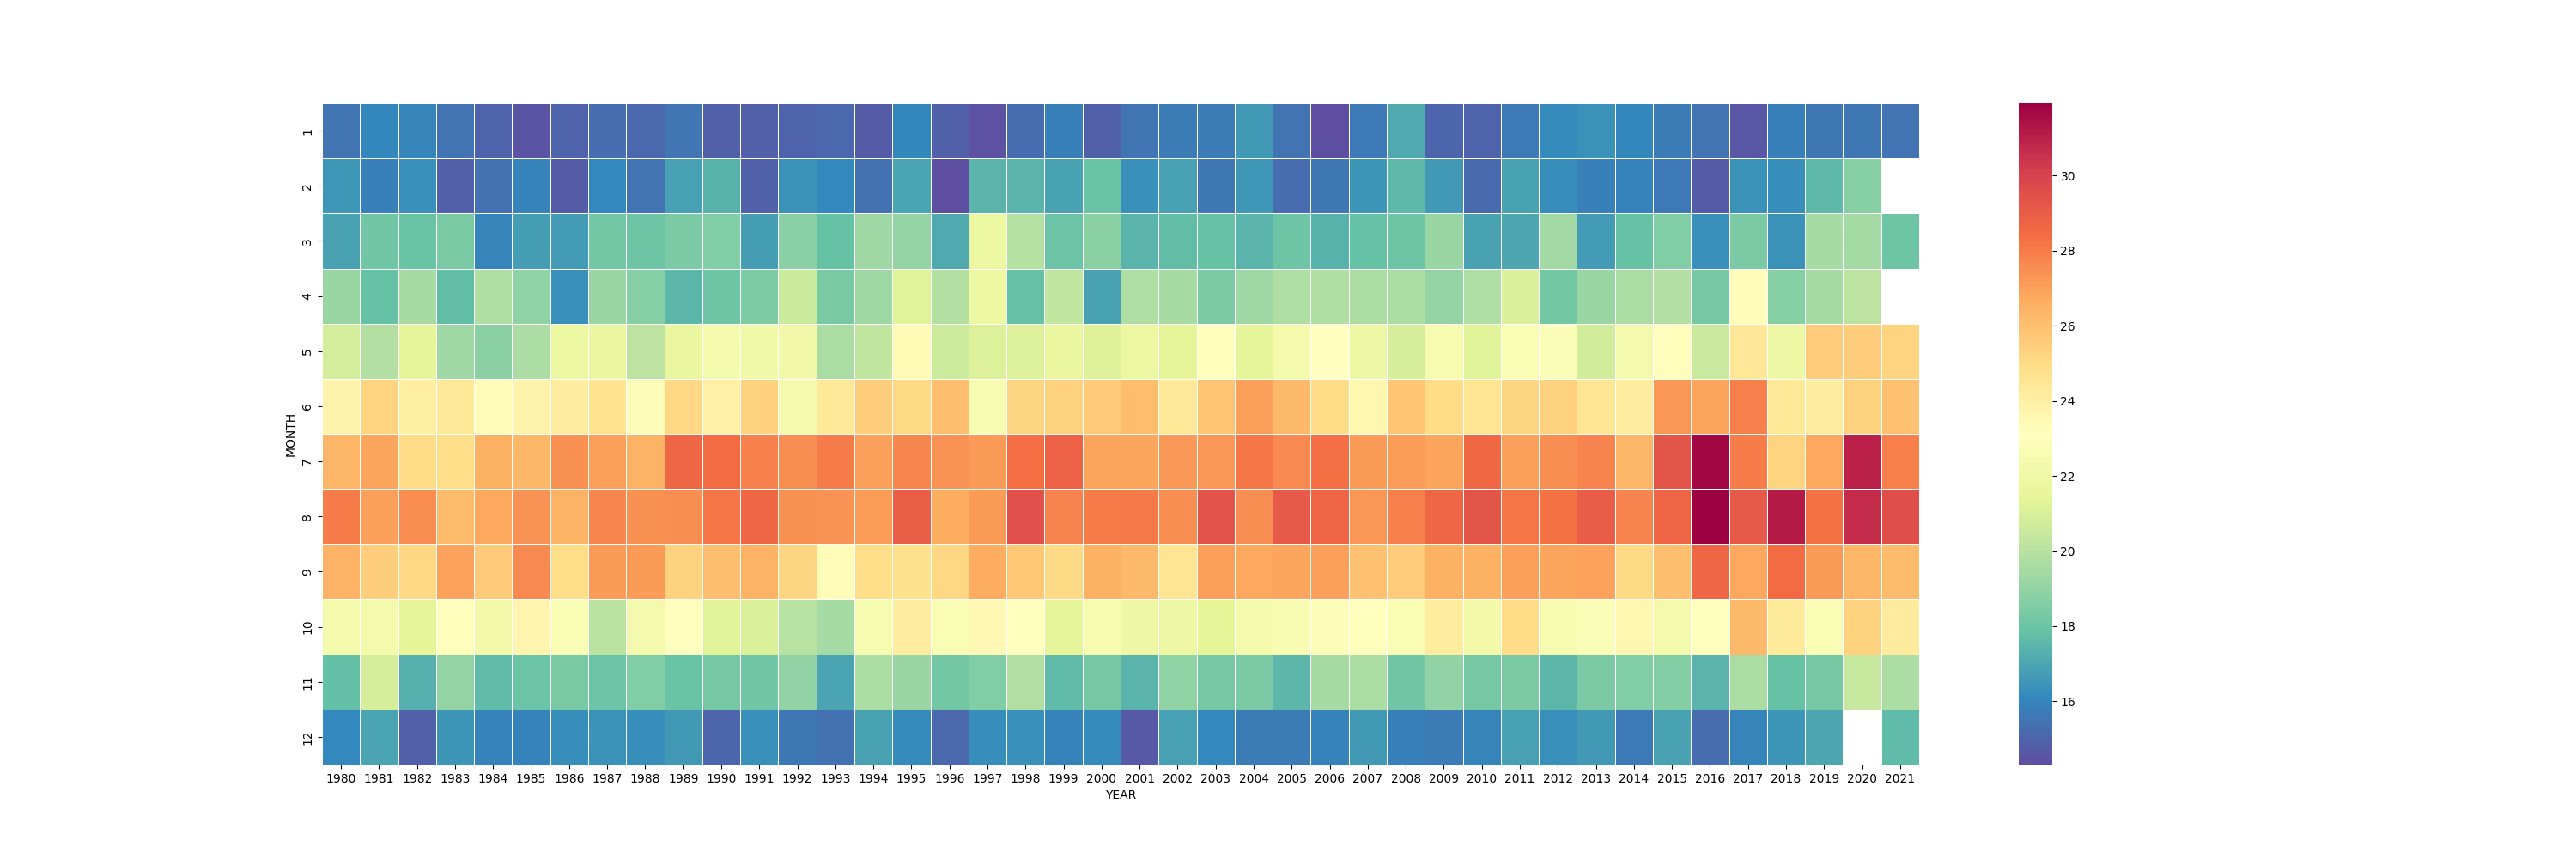

In [7]:

#São feitos os imports novamente de modo a permitir a visualização do gráfico
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

#Filtragem de modo a obter os dados relativos ao intervalo de anos [1980-2021]
df_anos = new_data.filter(((year(col("DATE"))) >= 1980) & ((year(col("DATE"))) <= 2021))

#Filtragem de modo a obter os valores relativos à temperatura máxima em Portugal
df_pais = df_anos.filter((col("PAÍS") == "Portugal") & (col("ELEMENT") == "TMAX"))
#Criação de uma nova coluna com os diversos anos
df_pais = df_pais.withColumn("YEAR",year(col("DATE")))
#Criação de uma nova coluna com os diversos meses
df_pais = df_pais.withColumn("MONTH",month(col("DATE")))

#É feito o agrupamento de dados por ano e mês, sendo realizada a média para os valores de temperatura
#e, por fim, é feita a ordenação por ordem crescente de ano
df_plot = (df_pais.select(col("YEAR"), col("MONTH"), col("DATA VALUE"))
           .groupBy(col("YEAR"), col("MONTH"))
           .agg(avg("DATA VALUE").alias("TMAX_AVG"))
           .orderBy(col("YEAR")).toPandas() )

#Construção e visualização do heatmap
plt.figure(figsize=(30,10))
temp_plot = df_plot.pivot("MONTH", "YEAR", "TMAX_AVG")
sns.heatmap(temp_plot, cmap="Spectral_r", linewidths=.5)

#Comando local para permitir a visualização do gráfico
%matplot plt           


In [8]:

#Função que, através dos parâmetros recebidos de temperatura mínima e máxima, retorna o valor categórico de temperatura 
def binner(min_temp, max_temp):
        if (min_temp is None) or (max_temp is None):
            return "unknown"
        else:
            if min_temp < -10:
                return "freezing cold"
            elif min_temp < -5:
                return "very cold"
            elif min_temp < 0:
                return "cold"
            elif max_temp < 10:
                return "normal"
            elif max_temp < 20:
                return "warm"
            elif max_temp < 30:
                return "hot"
            elif max_temp >= 30:
                return "very hot"
        return "normal"

#Passagem da função criada para o tipo User Defined Function, definindo o tipo utilizado como String
udf_binner_temp = udf(binner, StringType() )


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:

#Filtragem de modo a obter os dados contidos entre os anos [2000-2020] na Alemanha
df_filter = new_data.filter((year(col("DATE"))>=2000) & (year(col("DATE"))<=2020) & (col("PAÍS") == "Germany"))

#Filtragem de modo a obter todas as temperaturas máximas
df_max = df_filter.filter(col("ELEMENT") == "TMAX")

#Filtragem de modo a obter todas as temperaturas mínimas
df_min = df_filter.filter(col("ELEMENT") == "TMIN")
#Renomear as colunas de modo a evitar conflito de nomes aquando da função join
df_min = df_min.toDF("DATA","ELEMENTO","DATA VAL","ID","COUNTRY","CONTINENT")

#Criação de uma variável que contém duas colunas distintas, sendo uma preenchida com os valores da temperatura máxima
#e outra com os valores da temperatura mínima
df_temps = ( df_max.join(df_min).where(df_max["DATE"] == df_min["DATA"])
            .drop("ELEMENT","DATA","ELEMENTO","CONTINENT","COUNTRY","ID") )

#Renomear as colunas
df_temps = df_temps.toDF("DATE","MAX_TEMP","CÓDIGO","PAÍS","CONTINENTE","MIN_TEMP")

#Agrupação de dados através da data de observação, sendo que iremos realizar a média das temperaturas máximas e mínimas para cada dia
#Por fim os dados são ordenados por ordem crescente de data
df_grafico = ( df_temps.groupBy(col("DATE"))
             .agg(avg("MAX_TEMP"),avg("MIN_TEMP"))
             .orderBy(col("DATE"),ascending=True) )

#É criada uma nova coluna com os valores categóricos de temperatura, utilizando a função concebida anteriormente
df_grafico = df_grafico.withColumn("TEMP", udf_binner_temp(col("avg(MIN_TEMP)"), col("avg(MAX_TEMP)")))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

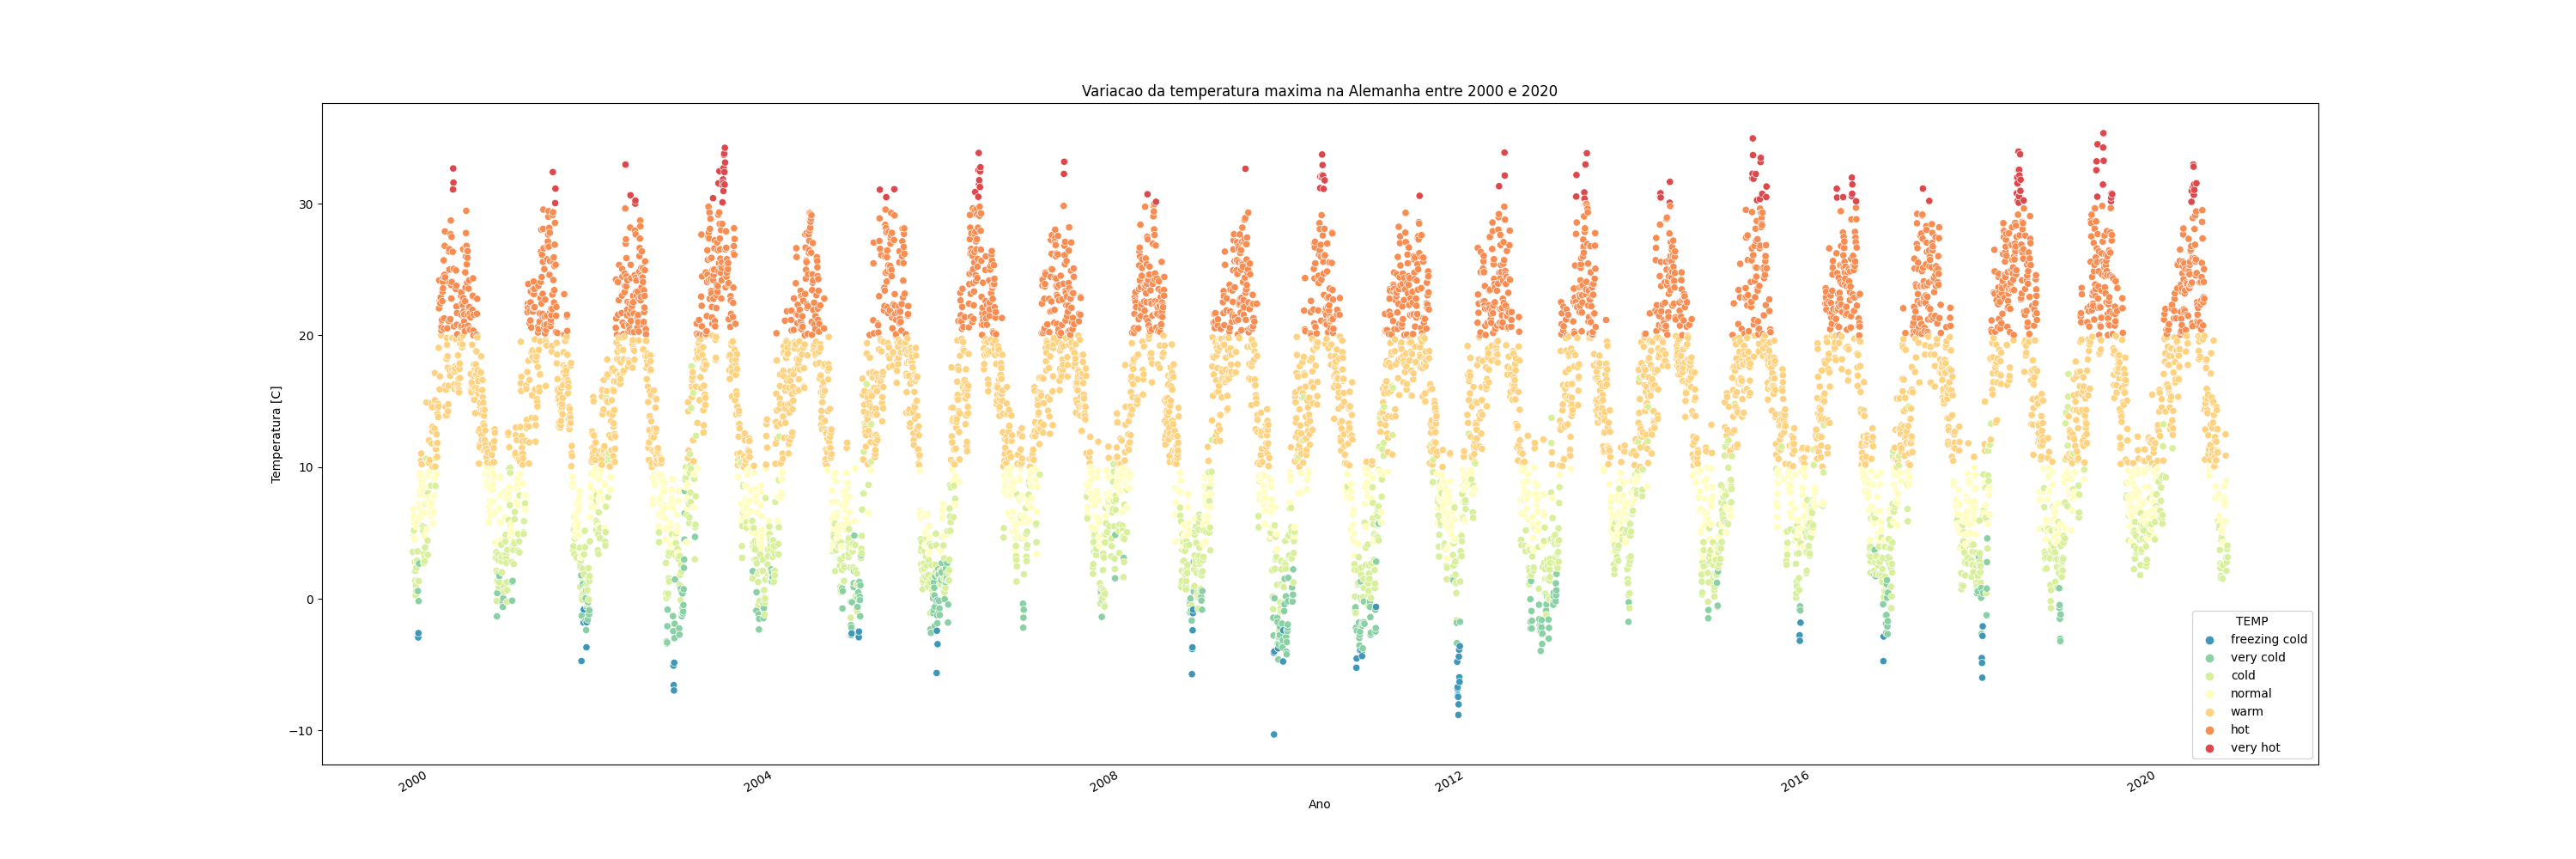

In [10]:

#São feitos os imports novamente de modo a permitir a visualização do gráfico
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns


#Produção e observação do gráfico que corresponde à variação da temperatura máxima na Alemanha entre 2000 e 2020  
fig, ax = plt.subplots(figsize=(30,10))
sns.scatterplot(hue="TEMP",hue_order=["freezing cold","very cold","cold","normal","warm","hot","very hot"],
                y="avg(MAX_TEMP)", x="DATE", data=df_grafico.toPandas(), palette="Spectral_r")
ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
ax.set_title("Variacao da temperatura maxima na Alemanha entre 2000 e 2020")
plt.xlabel("Ano")
plt.ylabel("Temperatura [C]")
plt.show()

#Comando local para permitir a visualização do gráfico
%matplot plt
